# Autonomous Driving - Automatic detection of vehicles on the road for vehicle tracking, vehicle counting, and road incident response

<span style='color:Purple; font-size:18px'> **Description of the Problem Statement** - Autonomous vehicles (AV) and intelligent transport systems (ITS) are the future of road transport. Automatic detection of vehicles on the road in real-time is essential for vehicle tracking, vehicle counting, and road incident response </span>

In [2]:
import os
import pandas as pd
import numpy as np
import glob as glob
import matplotlib.pyplot as plt
import cv2
import requests
import torch 
import shutil
import ultralytics
from ultralytics import YOLO

In [ ]:
# !pip install ultralytics

In [3]:
print(ultralytics.__file__)

C:\Users\Sonia\AppData\Local\Programs\Python\Python312\Lib\site-packages\ultralytics\__init__.py


In [42]:
# Define folder paths
parent_folder = "custom_model_training"
child_folders = ["data/raw", "data/processed", "models", "logs", "outputs"]

# Create folders
for folder in child_folders:
    os.makedirs(os.path.join(parent_folder, folder), exist_ok=True)

print("Folders created successfully.")

Folders created successfully.


<span style='color:Purple; font-size:16px'> **Task** - Fine-Tuning YOLO for Object Detection </span>

In [18]:
# Function to load YOLOv5 model
def load_yolov5_model():
    # Load the YOLOv5 model from the pre-trained weights available on the Ultralytics GitHub
    model = torch.hub.load('ultralytics/yolov5', 'yolov5s', trust_repo=True)  # 'yolov5s' is the small version
    return model

In [19]:
yolo_model = load_yolov5_model()

Using cache found in C:\Users\Sonia/.cache\torch\hub\ultralytics_yolov5_master
YOLOv5  2025-4-23 Python-3.12.5 torch-2.7.0+cpu CPU

Fusing layers... 
YOLOv5s summary: 213 layers, 7225885 parameters, 0 gradients, 16.4 GFLOPs
Adding AutoShape... 


In [4]:
label_dataframe = pd.read_csv("labels_new.csv")
label_dataframe.head()

,image_id,class_name,x_min,y_min,x_max,y_max
0,0,pickup_truck,213,34,255,50
1,0,car,194,78,273,122
2,0,car,155,27,183,35
3,0,articulated_truck,43,25,109,55
4,0,car,106,32,124,45


In [4]:
label_dataframe.shape

(351549, 6)

In [5]:
label_dataframe['class_name'].unique()

array(['pickup_truck', 'car', 'articulated_truck', 'bus', 'motorized_vehicle', 'work_van', 'single_unit_truck', 'pedestrian', 'bicycle', 'non-motorized_vehicle', 'motorcycle'], dtype=object)

In [19]:
enumerate(label_dataframe['class_name'].unique())

In [5]:
# Map class names to IDs
class_map = {name: idx for idx, name in enumerate(label_dataframe['class_name'].unique())}
print(class_map)

{'pickup_truck': 0, 'car': 1, 'articulated_truck': 2, 'bus': 3, 'motorized_vehicle': 4, 'work_van': 5, 'single_unit_truck': 6, 'pedestrian': 7, 'bicycle': 8, 'non-motorized_vehicle': 9, 'motorcycle': 10}


In [8]:
# Group by filename
for image_id, group in label_dataframe.groupby('image_id'):
    label_lines = []
    for _, row in group.iterrows():
        class_id = class_map[row['class_name']]
        x_min, y_min, x_max, y_max = row['x_min'], row['y_min'], row['x_max'], row['y_max']
        #img_w, img_h = row['img_width'], row['img_height']
        img_w, img_h = 640, 480
        
        
        # Convert to YOLO format
        x_center = ((x_min + x_max) / 2) / img_w
        y_center = ((y_min + y_max) / 2) / img_h
        width = (x_max - x_min) / img_w
        height = (y_max - y_min) / img_h

        line = f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}"
        label_lines.append(line)

    # Save to .txt file
    #txt_filename = os.path.splitext(filename)[0] + '.txt'
    txt_filename = f"{image_id:08}.txt"
    with open(os.path.join("labels", txt_filename), 'w') as f:
        f.write('\n'.join(label_lines))

In [13]:
def convert_bbox_to_yolo(x_min, y_min, x_max, y_max, img_width, img_height):
    """
    Convert bounding box from pixel format to YOLO format.
    
    Parameters:
        x_min, y_min, x_max, y_max: Bounding box in pixels
        img_width, img_height: Dimensions of the image in pixels
        
    Returns:
        Tuple: (x_center, y_center, width, height) in YOLO normalized format
    """
    x_center = (x_min + x_max) / 2 / img_width
    y_center = (y_min + y_max) / 2 / img_height
    width = (x_max - x_min) / img_width
    height = (y_max - y_min) / img_height
    return round(x_center, 6), round(y_center, 6), round(width, 6), round(height, 6)

In [14]:
# Suppose your image is 640x480
img_w, img_h = 640, 480

# A bounding box: (x_min, y_min, x_max, y_max)
bbox = (100, 50, 200, 150)

# Convert it
x_c, y_c, w, h = convert_bbox_to_yolo(*bbox, img_w, img_h)
print("YOLO Format:", x_c, y_c, w, h)

YOLO Format: 0.234375 0.208333 0.15625 0.208333


In [6]:
SPLIT_RATIO = 0.8  # 80% train, 20% validation

In [7]:
# Get all image files
images_files = []
for file in os.listdir('Images'):
    if file.endswith(('.jpg', '.png')):
        images_files.append(file)     

In [8]:
len(images_files)

5626

In [9]:
split_index = int(len(images_files) * SPLIT_RATIO)
split_index

4500

In [10]:
split_data = {
    "train": images_files[:split_index],
    "val": images_files[split_index:]
}

In [11]:
split_data['train'][8]

'00000008.jpg'

In [12]:
len(split_data['train'])

4500

In [13]:
# Paths
dirs = ['train', 'val']
image_dir = "dataset/images"
label_dir = "dataset/labels"

In [14]:
img_file1 = '00000008.jpg'
img_file1.rsplit('.', 1)[0] + ".txt"

'00000008.txt'

In [17]:
# Copy images and labels
for directory in dirs:
    for img_file in split_data[directory]:
        label_file = img_file.rsplit('.', 1)[0] + ".txt"
        # Copy image
        shutil.copy(os.path.join("Images", img_file),
                    os.path.join("dataset", "images", directory, img_file))
        # Copy label
        shutil.copy(os.path.join("labels", label_file),
                    os.path.join("dataset", "labels", directory, label_file))

In [15]:
len(os.listdir('dataset/images/train'))

4500

In [16]:
len(os.listdir('dataset/images/val'))

1126

In [17]:
len(os.listdir('dataset/labels/train'))

4500

In [18]:
len(os.listdir('dataset/labels/val'))

1126

In [7]:
dir1 = "Images/"
path = dir1 + images_files[5]
path

'Images/00000005.jpg'

In [8]:
path = "Images/" + images_files[5]
path

'Images/00000005.jpg'

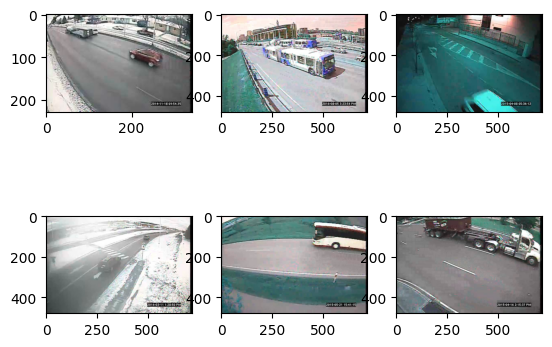

In [19]:
# Load images and create dataset
dataset = []
for count in range(6):
    ax = plt.subplot(2, 3, count+1)
    path = "Images/" + images_files[count]
    image = cv2.imread(path)
    dataset.append(image)
    plt.imshow(image)


In [ ]:
#image = cv2.imread(path)
#plt.imshow(image)

In [20]:
dataset[0].shape

(228, 342, 3)

In [25]:
 print("dataset/images/train/" + split_data['train'][5])

dataset/images/train/00000005.jpg


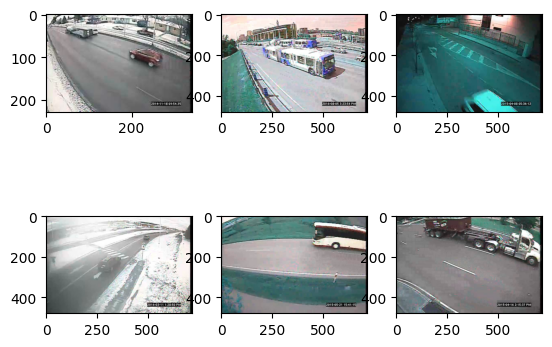

In [20]:
# Load images and create dataset
dataset = []
for count in range(6):
    ax = plt.subplot(2, 3, count+1)
    path = "dataset/images/train/" + split_data['train'][count]
    image = cv2.imread(path)
    dataset.append(image)
    plt.imshow(image)

In [21]:
# Function to preprocess the image
def preprocess_image(image_path):
    
    # Read the image using OpenCV
    img = cv2.imread(image_path)

    # Convert the image from BGR to RGB (as YOLOv5 uses RGB)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Resize the image to 640x640 (YOLOv5 expects a 640x640 input)
    img_resized = cv2.resize(img, (640, 640))

    return img_resized

In [22]:
len(dataset)

6

In [23]:
img_resized = []
for i in range(6):
    image_path = "dataset/images/train/" + split_data['train'][i]
    img_resized.append(preprocess_image(image_path))
    
print(img_resized[0].shape)

(640, 640, 3)


In [ ]:
if not os.path.exists('yolov5'):

    !git clone https://github.com/ultralytics/yolov5.git

%cd yolov5/

#Run it once, restart the session and then run the same code snippet with this command commented out.
#!pip3 install -r requirements.txt

In [30]:
# Function to perform object detection
def detect_objects(model, img):
    
    # Perform inference using the YOLOv5 model
    results = model(img)

    # The results object contains a lot of information (bounding boxes, labels, confidence scores)
    # We will extract the pandas DataFrame containing the predictions
    detections = results.pandas().xywh[0]  # We take the first (and only) item, which contains the detections
    
    return detections, results

In [31]:
# Function to draw bounding boxes on the image
def draw_bounding_boxes(img, detections):
    
    # Loop through the detections and draw the bounding boxes
    for _, detection in detections.iterrows():
        
        # Extract the bounding box parameters and class information from the detection
        x_center, y_center, width, height = detection['xcenter'], detection['ycenter'], detection['width'], detection['height']
        class_name = detection['name']  # The class of the detected object
        confidence = detection['confidence']  # The confidence score of the detection

        # Convert from normalized coordinates (center-based) to pixel coordinates
        # The detection's coordinates are normalized with respect to the image size, so we need to 
        # convert them back to absolute pixel coordinates.
        
        # Get the image dimensions (height, width)
        img_height, img_width, _ = img.shape
        
        # Calculate the top-left (x1, y1) and bottom-right (x2, y2) corners of the bounding box.
        # These are calculated by adjusting the center coordinates based on the width and height.
        x1 = int((x_center - (width / 2)))  # Left side of the box
        y1 = int((y_center - (height / 2)))  # Top side of the box

        x2 = int((x_center + (width / 2)))  # Right side of the box
        y2 = int((y_center + (height / 2)))  # Bottom side of the box

        # Draw the bounding box on the image using OpenCV's rectangle function.
        # The arguments (x1, y1) and (x2, y2) define the top-left and bottom-right corners of the box.
        # The color is set to (0, 0, 0) for black, and the thickness of the rectangle is set to 1.
        cv2.rectangle(img, (x1, y1), (x2, y2), (0, 255, 0), 1)  # Black color for bounding box
        
        # Create a label to display the class name and confidence score.
        # Format the label as "class_name confidence", rounding the confidence to 2 decimal places.
        label = f"{class_name} {confidence:.2f}"
        
        # Place the label text on the image using OpenCV's putText function.
        # The position of the label is slightly above the top-left corner of the bounding box (x1, y1 - 10).
        # The font used is FONT_HERSHEY_SIMPLEX with a font size of 0.3, color black (0, 0, 0), and thickness 1.
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.3, (0, 255, 0), 1)

    # Return the modified image with the bounding boxes and labels
    return img

In [33]:
# Function to display the image
def display_image(img):
    
    # Convert the image from RGB to BGR (OpenCV uses BGR by default)
    img_bgr = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
    
    # Display the image with bounding boxes using OpenCV
    cv2.imshow("YOLOv5 Object Detection", img_bgr)
    cv2.waitKey(0)  # Wait for a key press to close the image window
    cv2.destroyAllWindows()

In [35]:
# Perform object detection
detections, results = detect_objects(yolo_model, img_resized[0])

C:\Users\Sonia/.cache\torch\hub\ultralytics_yolov5_master\models\common.py:906: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with amp.autocast(autocast):


In [36]:
detections

,xcenter,ycenter,width,height,confidence,class,name
0,438.252838,286.939514,145.394104,122.451553,0.700001,2,car
1,318.067657,91.444397,45.617615,26.000031,0.671581,2,car
2,168.216431,121.375031,120.754211,69.472229,0.374940,7,truck


In [38]:
# Display the output image with bounding boxes
# labeled_img = draw_bounding_boxes(img_resized , detections)

labeled_img_1 = draw_bounding_boxes(img_resized[0] , detections.sort_values('confidence', ascending = False).head(10))


In [40]:
display_image(labeled_img_1)

In [ ]:
os.chdir('C:\\Users\\Sonia\\Python_Programs\\Capstone\\01_Capstone\\yolov5')

In [29]:
os.getcwd()

'C:\\Users\\Sonia\\Python_Programs\\Capstone-01\\01_Capstone-try1'

In [ ]:
# !python train.py --img 640 --batch 16 --epochs 100 --data custom_data.yaml --weights yolov5s.pt --name custom_yolov5

In [ ]:
# !tensorboard --logdir runs/train

In [30]:
# Load a pre-trained YOLOv8 model for object detection
model = YOLO('yolov8n.pt')  # 'n' = nano model, very small and fast. You can also use yolov8s.pt, yolov8m.pt, etc.


In [ ]:
# Train the model
# model.train(data="custom_data.yaml", epochs=1, imgsz=640)


In [32]:
# Load fine-tuned YOLO model
model = YOLO('runs/detect/train5/weights/best.pt')

In [ ]:
# Validate model performance on validation set
metrics = model.val()

In [ ]:
print(metrics)

In [44]:
metrics.results_dict

{'metrics/precision(B)': np.float64(0.6491450012595851),
 'metrics/recall(B)': np.float64(0.08878292107875745),
 'metrics/mAP50(B)': np.float64(0.08090781799742308),
 'metrics/mAP50-95(B)': np.float64(0.044127771759031216),
 'fitness': np.float64(0.04780577638287041)}

In [49]:
# Inference Results

image_path1 = 'dataset/images/train/00000001.jpg'
image_path2 = 'dataset/images/train/00000211.jpg'

resized_image = preprocess_image(image_path2)
# Run object detection on an image
results = model(resized_image)

# Access the first prediction result
result = results[0]
# Print number of detections
print(f"Detections: {len(result.boxes)}")

# Print detection details
for box in result.boxes:
    print("Class:", model.names[int(box.cls)])
    print("Confidence:", float(box.conf))
    print("Bounding Box [x1, y1, x2, y2]:", box.xyxy[0].tolist())

# Show results
result.show()

# If you want to save results (bounding boxes etc.)
#result.save(save_dir='runs/detect')


0: 640x640 2 cars, 230.4ms
Speed: 5.3ms preprocess, 230.4ms inference, 2.9ms postprocess per image at shape (1, 3, 640, 640)
Detections: 2
Class: car
Confidence: 0.791540801525116
Bounding Box [x1, y1, x2, y2]: [479.7445983886719, 260.8424072265625, 639.78369140625, 379.33251953125]
Class: car
Confidence: 0.6191530227661133
Bounding Box [x1, y1, x2, y2]: [466.21392822265625, 354.01885986328125, 639.8898315429688, 538.8812866210938]



0: 448x640 5 cars, 171.3ms
Speed: 5.3ms preprocess, 171.3ms inference, 1.7ms postprocess per image at shape (1, 3, 448, 640)


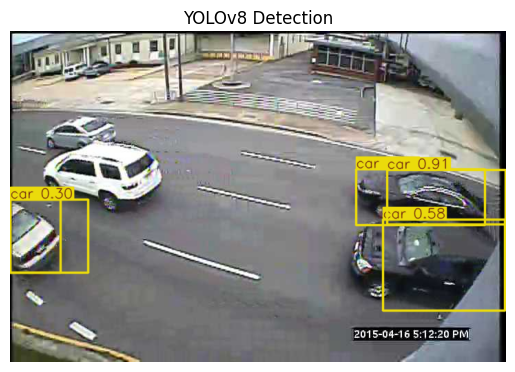

In [48]:
# Plot result with Matplotlib
image_path = 'dataset/images/train/00000211.jpg'
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

#results = model(image_path)
results = model(img)
annotated_frame = results[0].plot()

plt.imshow(annotated_frame)
plt.axis('off')
plt.title("YOLOv8 Detection")
plt.show()

In [50]:
# Load a pre-trained YOLOv8 classification model
model_builtin = YOLO('yolov8n-cls.pt')  # 'n-cls' = nano model for classification

# Run classification on an image
image_path = 'dataset/images/train/00000211.jpg'
resized_image = preprocess_image(image_path)

results = model_builtin(resized_image)

#print(results[0])

# Print the top class prediction
#print(results[0].probs.top1)   # Top-1 predicted class index
#print(results[0].names)        # Class names

# Show classified image
results[0].show()


0: 224x224 racer 0.25, sports_car 0.13, half_track 0.07, dock 0.05, amphibian 0.05, 31.2ms
Speed: 11.9ms preprocess, 31.2ms inference, 0.1ms postprocess per image at shape (1, 3, 224, 224)


In [55]:
model_yolov8 = YOLO("yolov8n.pt")  # detection model
image_path1 = 'dataset/images/train/00000001.jpg'
image_path2 = 'dataset/images/train/00000211.jpg'

resized_image = preprocess_image(image_path2)
#results = model_yolov8(resized_image)  # Run inference
results = model_yolov8(image_path2)  # Run inference

result = results[0]
# Extract detection info
boxes = result.boxes
for box in boxes:
    class_id = int(box.cls[0])
    confidence = float(box.conf[0])
    xyxy = box.xyxy[0].tolist()
    
    class_name = model.names[class_id]
    print(f"Detected: {class_name} ({confidence:.2f}) at {xyxy}")
result.show()


image 1/1 C:\Users\Sonia\Python_Programs\Capstone-01\01_Capstone-try1\dataset\images\train\00000211.jpg: 448x640 6 cars, 2 airplanes, 198.7ms
Speed: 7.1ms preprocess, 198.7ms inference, 2.3ms postprocess per image at shape (1, 3, 448, 640)
Detected: articulated_truck (0.81) at [2.2904326915740967, 246.88720703125, 73.81356048583984, 350.3258972167969]
Detected: articulated_truck (0.76) at [48.17216491699219, 156.69857788085938, 222.42092895507812, 261.2087097167969]
Detected: articulated_truck (0.76) at [49.91559600830078, 122.60314178466797, 154.54080200195312, 172.66494750976562]
Detected: motorized_vehicle (0.46) at [270.2474060058594, 218.07421875, 409.8737487792969, 261.0965270996094]
Detected: articulated_truck (0.44) at [107.16520690917969, 44.09586715698242, 147.34278869628906, 65.9946060180664]
Detected: motorized_vehicle (0.44) at [331.4512023925781, 169.49649047851562, 446.0406494140625, 201.18911743164062]
Detected: articulated_truck (0.31) at [77.95513916015625, 43.353370